In [1]:
import h5py
import glob
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import *
from tensorflow import keras
from tensorflow.keras import layers, models, Model
from sklearn.metrics import roc_curve, auc
import tensorflow.keras.backend as K
import qkeras
from qkeras import *

np.random.seed(42)
tf.random.set_seed(42)

## read data

In [2]:
data_files = sorted(glob.glob('recon3D/recon3D_d*.parquet'))
labels_files = sorted(glob.glob('labels/labels_d*.parquet'))

data_list = []
labels_list = []
n_files = 0
for rf, lf in zip(data_files, labels_files):
    if n_files < 40:
        d = pd.read_parquet(rf)
        l = pd.read_parquet(lf)
        data_list.append(d)
        labels_list.append(l)
    n_files += 1

data = pd.concat(data_list, ignore_index=True)
labels = pd.concat(labels_list, ignore_index=True)

In [3]:
data

,0,1,2,3,4,5,6,7,8,9,...,5450,5451,5452,5453,5454,5455,5456,5457,5458,5459
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1999872,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1999873,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1999874,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1999875,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
labels

,x-entry,y-entry,z-entry,n_x,n_y,n_z,number_eh_pairs,y-local,pt,cotAlpha,cotBeta,y-midplane,x-midplane
0,4.198420,21.228418,100.0,0.768970,-0.160933,-0.634940,10570.0,-6.94104,0.656019,-1.211091,0.253462,8.555331,64.752961
1,129.548080,-1.019828,100.0,-1.205132,-0.087774,-0.635886,13639.0,-4.33669,0.637776,1.895201,0.138034,-7.921537,34.788013
2,-51.428604,13.324836,100.0,1.542896,-0.322932,-1.512257,10535.0,-7.79379,-1.547540,-1.020260,0.213543,2.647683,-0.415582
3,-212.990051,5.540823,100.0,1.451834,-0.039285,-0.467361,23534.0,-2.67448,0.468860,-3.106451,0.084057,1.337969,-57.667506
4,60.380154,9.740603,100.0,-0.110369,-0.034764,-0.554253,6478.0,-2.11685,0.555289,0.199131,0.062722,6.604490,50.423600
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1999872,23.303335,-7.093988,100.0,-0.316715,0.137576,-0.452771,9011.0,7.18529,-0.473535,0.699504,-0.303853,8.098681,-11.671851
1999873,157.907959,-6.589191,100.0,-3.975201,-0.334479,-1.590787,19255.0,-6.79393,1.625030,2.498890,0.210260,-17.102195,32.963482
1999874,-76.683937,3.956885,100.0,0.443910,-0.104577,-0.531471,7442.0,-5.42431,0.541693,-0.835248,0.196769,-5.881563,-34.921545
1999875,-72.115654,2.938174,100.0,0.379667,-0.205288,-1.216183,55114.0,-6.45043,-1.233360,-0.312179,0.168797,-5.501674,-56.506695


In [5]:
data = data.to_numpy()
data = np.reshape(data, (-1, 20, 13, 21))

## plot data

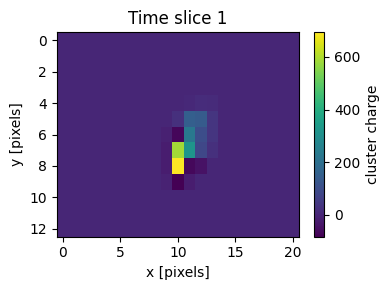

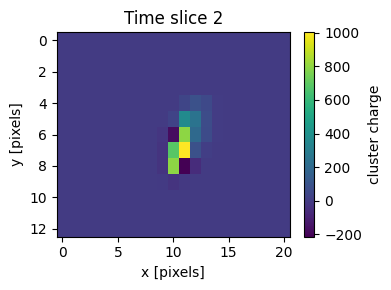

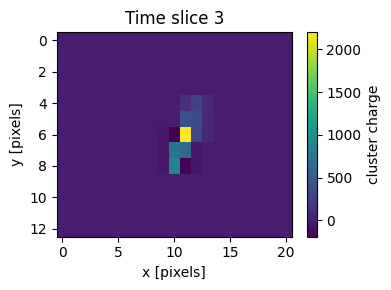

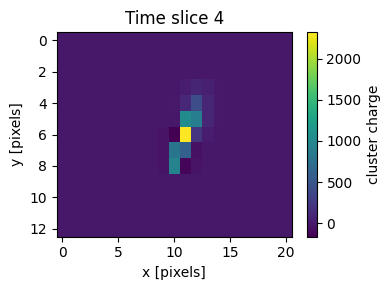

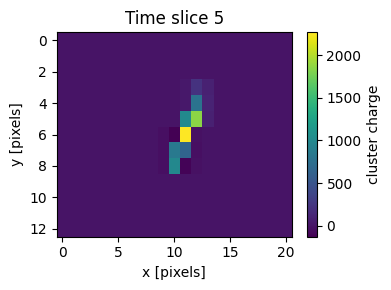

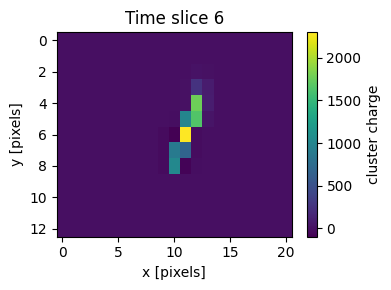

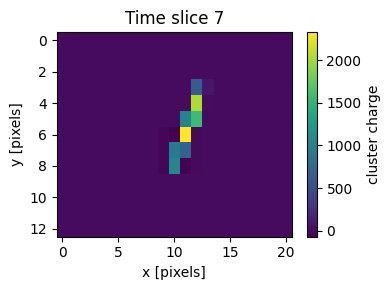

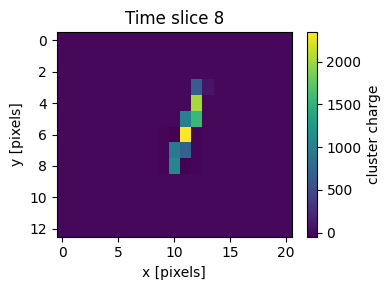

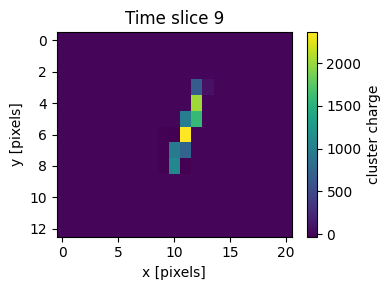

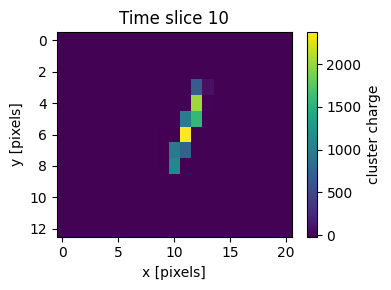

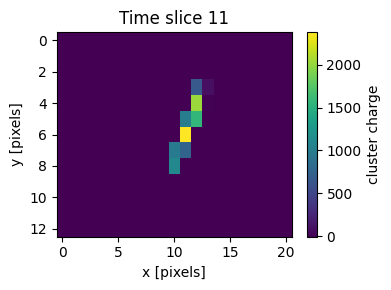

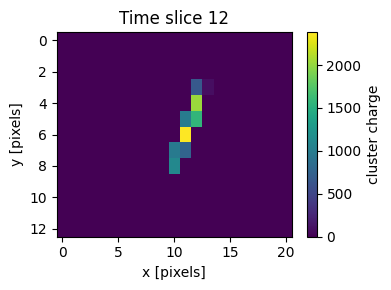

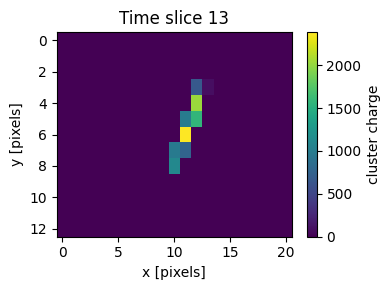

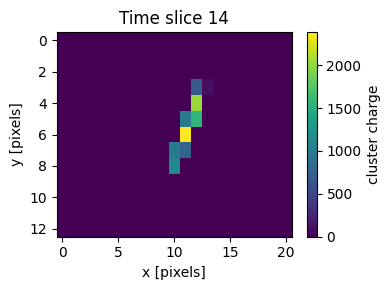

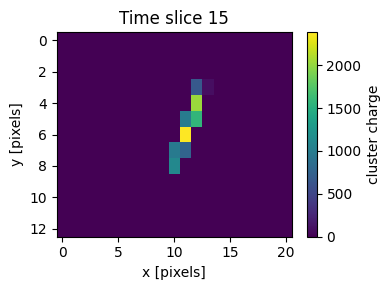

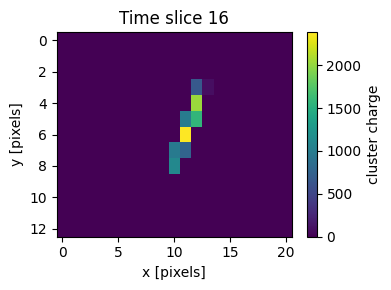

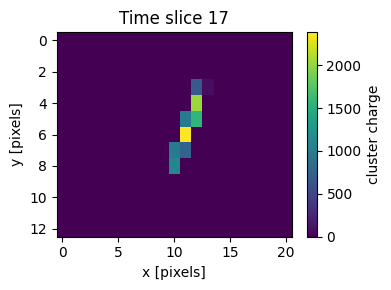

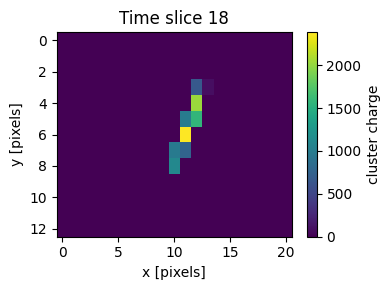

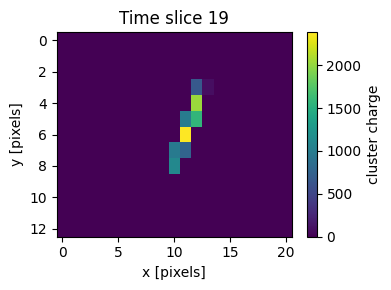

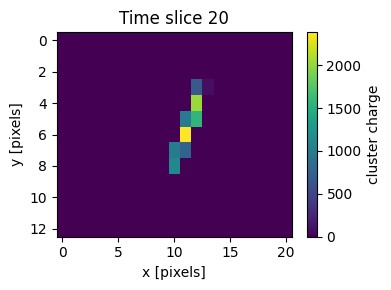

In [6]:
for i in range(data[0].shape[0]):
    plt.figure(figsize=(4, 3))
    plt.imshow(data[0][i], aspect='auto', cmap='viridis')
    plt.title(f'Time slice {i+1}')
    plt.xlabel('x [pixels]')
    plt.ylabel('y [pixels]')
    plt.colorbar(label='cluster charge')
    plt.tight_layout()
    plt.show()

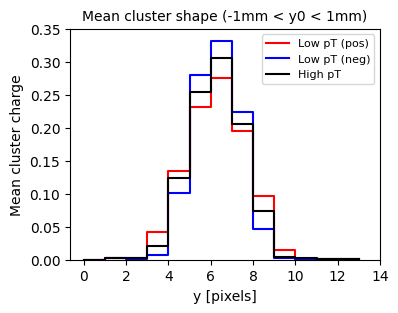

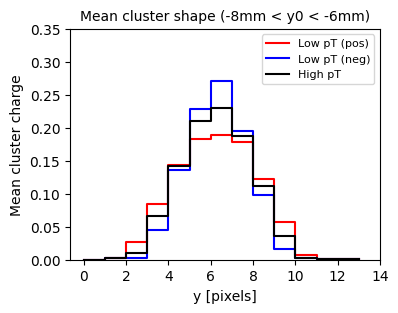

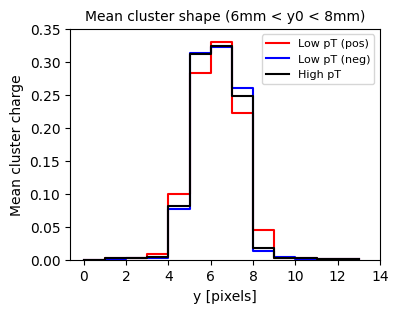

In [7]:
y0_range = [(-1, 1), (-8, -6), (6, 8)]
for r in y0_range:
    data_y0range = data[(labels['y-local'] > r[0]) & (labels['y-local'] < r[1])]
    labels_y0range = labels[(labels['y-local'] > r[0]) & (labels['y-local'] < r[1])]
    
    # take the last time slice, and sum over x to get y profile
    y_profile = data_y0range[:, -1, :, :].sum(axis = -1)
    
    y_profile_low_pos = y_profile[(labels_y0range['pt'] < 0.2) & (labels_y0range['pt'] > 0)]
    y_profile_low_neg = y_profile[(labels_y0range['pt'] > -0.2) & (labels_y0range['pt'] < 0)]
    y_profile_high = y_profile[(labels_y0range['pt'] > 0.2) | (labels_y0range['pt'] < -0.2)]
    
    y_profile_low_pos_mean = y_profile_low_pos.mean(axis = 0)
    y_profile_low_neg_mean = y_profile_low_neg.mean(axis = 0)
    y_profile_high_mean = y_profile_high.mean(axis = 0)
    
    edges = np.arange(len(y_profile_low_pos_mean) + 1)
    
    y_profile_low_pos_mean = np.concatenate(([0], y_profile_low_pos_mean))
    y_profile_low_neg_mean = np.concatenate(([0], y_profile_low_neg_mean))
    y_profile_high_mean = np.concatenate(([0], y_profile_high_mean))
    
    plt.figure(figsize=(4, 3))
    plt.step(edges, y_profile_low_pos_mean/np.sum(y_profile_low_pos_mean), where='post', label = 'Low pT (pos)', color='red')
    plt.step(edges, y_profile_low_neg_mean/np.sum(y_profile_low_neg_mean), where='post', label = 'Low pT (neg)', color='blue')
    plt.step(edges, y_profile_high_mean/np.sum(y_profile_high_mean), where='post', label = 'High pT', color='black')
    plt.title(f"Mean cluster shape ({r[0]}mm < y0 < {r[1]}mm)", size=10)
    #plt.ylim(0, max(y_profile_low_neg_mean)*1.25)
    plt.ylim(0, 0.35)
    plt.xlabel("y [pixels]")
    plt.ylabel("Mean cluster charge")
    plt.xticks(np.arange(0, len(y_profile_low_pos_mean) + 1, 2))
    plt.legend(fontsize=8)
    plt.show()

## prepare training data

In [21]:
y_profile = data[:, -1, :, :].sum(axis = -1)
y0 = labels['y-local'].to_numpy().reshape(-1, 1)

X = np.hstack((y0, y_profile))

Y = np.zeros((labels['pt'].size, 3))
Y[:, 2] = 1
Y[np.where((labels['pt'] >= 0) & (labels['pt'] < 0.2))] = [1, 0, 0]
Y[np.where((labels['pt'] < 0) & (labels['pt'] > -0.2))] = [0, 1, 0]

pt_truth = labels['pt'].to_numpy()

print(X.shape)
print(Y.shape)
print(np.sum(Y, axis=0))
print(pt_truth.shape)

(1999877, 14)
(1999877, 3)
[  53232.   51160. 1895485.]
(1999877,)


In [22]:
class_indices = np.argmax(Y, axis=1)

n_samples_per_class = int(min(np.sum(Y, axis=0)))

balanced_indices = []
for cls in range(Y.shape[1]):
    cls_indices = np.where(class_indices == cls)[0]
    sampled_indices = np.random.choice(cls_indices, n_samples_per_class, replace=False)
    balanced_indices.extend(sampled_indices)

np.random.shuffle(balanced_indices)

X = X[balanced_indices]
Y = Y[balanced_indices]
pt_truth = pt_truth[balanced_indices]

print(X.shape)
print(Y.shape)
print(np.sum(Y, axis=0))
print(pt_truth.shape)

(153480, 14)
(153480, 3)
[51160. 51160. 51160.]
(153480,)


In [23]:
train_ratio = 0.6
val_ratio = 0.2
test_ratio = 1 - train_ratio - val_ratio
X_train_val, X_test, Y_train_val, Y_test = train_test_split(X, Y, test_size = test_ratio, random_state = 42)
X_train, X_val, Y_train, Y_val = train_test_split(X_train_val, Y_train_val, test_size = val_ratio/(val_ratio + train_ratio), random_state = 42)

pt_truth_train_val, pt_truth_test = train_test_split(pt_truth, test_size = test_ratio, random_state = 42)
print('X_train shape: ' + str(X_train.shape))
print('X_val   shape: ' + str(X_val.shape))
print('X_test  shape: ' + str(X_test.shape))
print('Y_train shape: ' + str(Y_train.shape))
print('Y_val   shape: ' + str(Y_val.shape))
print('Y_test  shape: ' + str(Y_test.shape))

X_train shape: (92088, 14)
X_val   shape: (30696, 14)
X_test  shape: (30696, 14)
Y_train shape: (92088, 3)
Y_val   shape: (30696, 3)
Y_test  shape: (30696, 3)


In [11]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

## model

In [12]:
quantizer = quantized_bits(8, 0, alpha=1)
quantized_relu = 'quantized_relu(8, 0)'

x_input = keras.Input(shape=(14,), name='input')

x = QDense(128, use_bias=True, name='dense1', kernel_quantizer=quantizer, bias_quantizer=quantizer)(x_input)
x = QActivation(quantized_relu, name='relu1')(x)
    
x = QDense(3, use_bias=True, name='dense2', kernel_quantizer=quantizer, bias_quantizer=quantizer)(x)
x = layers.Softmax(name='softmax')(x)

model = keras.Model(x_input, x, name='model')

model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.005),
              loss='categorical_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 14)]              0         
                                                                 
 dense1 (QDense)             (None, 128)               1920      
                                                                 
 relu1 (QActivation)         (None, 128)               0         
                                                                 
 dense2 (QDense)             (None, 3)                 387       
                                                                 
 softmax (Softmax)           (None, 3)                 0         
                                                                 
Total params: 2307 (9.01 KB)
Trainable params: 2307 (9.01 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [13]:
history = model.fit(X_train, Y_train,
                    validation_data = (X_val, Y_val),
                    epochs=60, batch_size=128)

Epoch 1/60
720/720 [==============================] - 1s 781us/step - loss: 0.7522 - accuracy: 0.6643 - val_loss: 0.6653 - val_accuracy: 0.7165
Epoch 2/60
720/720 [==============================] - 0s 632us/step - loss: 0.6429 - accuracy: 0.7228 - val_loss: 0.6384 - val_accuracy: 0.7282
Epoch 3/60
720/720 [==============================] - 0s 628us/step - loss: 0.6194 - accuracy: 0.7322 - val_loss: 0.6260 - val_accuracy: 0.7301
Epoch 4/60
720/720 [==============================] - 0s 637us/step - loss: 0.6072 - accuracy: 0.7360 - val_loss: 0.6097 - val_accuracy: 0.7326
Epoch 5/60
720/720 [==============================] - 0s 636us/step - loss: 0.5969 - accuracy: 0.7393 - val_loss: 0.6237 - val_accuracy: 0.7296
Epoch 6/60
720/720 [==============================] - 0s 641us/step - loss: 0.5927 - accuracy: 0.7415 - val_loss: 0.6070 - val_accuracy: 0.7351
Epoch 7/60
720/720 [==============================] - 0s 648us/step - loss: 0.5894 - accuracy: 0.7429 - val_loss: 0.6066 - val_accuracy:

Text(0, 0.5, 'Loss')

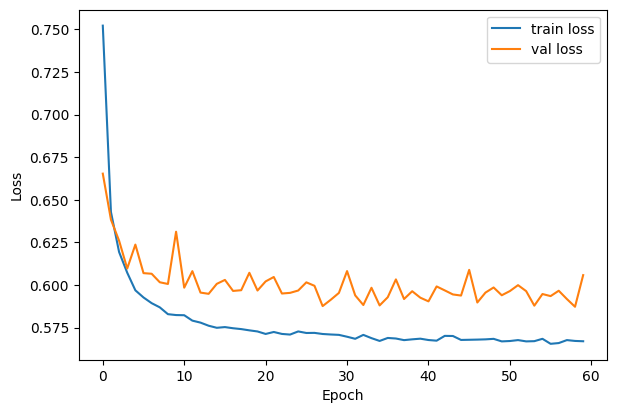

In [14]:
plt.figure(figsize = (15,10))
axes = plt.subplot(2, 2, 1)
axes.plot(history.history['loss'], label = 'train loss')
axes.plot(history.history['val_loss'], label = 'val loss')
axes.legend(loc = "upper right")
axes.set_xlabel('Epoch')
axes.set_ylabel('Loss')

In [15]:
Y_pred = model.predict(X_test)
print("Accuracy: {}".format(accuracy_score(np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1))))

960/960 [==============================] - 0s 249us/step
Accuracy: 0.7240682825123794


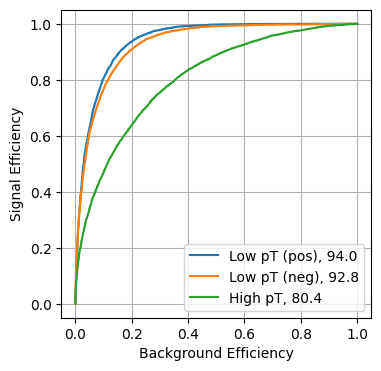

In [18]:
def plot_roc(y_test, y_pred, labels):
    for x, label in enumerate(labels):        
        fpr, tpr, _ = roc_curve(y_test[:, x], y_pred[:, x])
        plt.plot(fpr, tpr, label='{0}, {1:.1f}'.format(label, auc(fpr, tpr)*100.), linestyle='-')
    #plt.semilogy()
    #plt.semilogx()
    plt.ylabel("Signal Efficiency")
    plt.xlabel("Background Efficiency")
    #plt.ylim(0.00001, 1)
    #plt.xlim(0.00001, 1)
    plt.grid(True)
    plt.legend(loc='best', fontsize=10)  
    
plt.figure(figsize=(4, 4))
plot_roc(Y_test, Y_pred, ['Low pT (pos)','Low pT (neg)','High pT'])

In [51]:
y_profile = data[:, -1, :, :].sum(axis = -1)
y0 = labels['y-local'].to_numpy().reshape(-1, 1)

X = np.hstack((y0, y_profile))

Y = np.zeros((labels['pt'].size, 3))
Y[:, 2] = 1
Y[np.where((labels['pt'] >= 0) & (labels['pt'] < 0.2))] = [1, 0, 0]
Y[np.where((labels['pt'] < 0) & (labels['pt'] > -0.2))] = [0, 1, 0]

pt_truth_test = labels['pt'].to_numpy()

print(X.shape)
print(Y.shape)
print(np.sum(Y, axis=0))
print(pt_truth.shape)

(1999877, 14)
(1999877, 3)
[  53232.   51160. 1895485.]
(153480,)


In [52]:
X = scaler.transform(X)

In [53]:
Y_pred = model.predict(X)

62497/62497 [==============================] - 15s 234us/step


/var/folders/k_/3rw365c56w9f02q8nb4v2r4r0000gn/T/ipykernel_41085/239361728.py:9: RuntimeWarning: invalid value encountered in divide
  proportions = class_001_counts / total_counts
/var/folders/k_/3rw365c56w9f02q8nb4v2r4r0000gn/T/ipykernel_41085/239361728.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


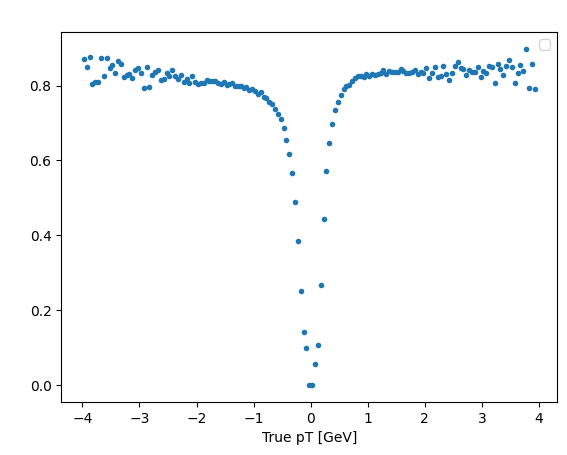

In [60]:
custom_bins = np.arange(-4, 4, 0.05)
bin_centers = 0.5 * (custom_bins[:-1] + custom_bins[1:])

indices_001 = np.argmax(Y_pred, axis=1) == 2

total_counts, _ = np.histogram(pt_truth_test, bins=custom_bins)
class_001_counts, _ = np.histogram(pt_truth_test[indices_001], bins=custom_bins)

proportions = class_001_counts / total_counts
proportions = np.nan_to_num(proportions)

plt.scatter(bin_centers, proportions, marker='.')
plt.xlabel('True pT [GeV]')
plt.ylabel(' ')
plt.title(' ')
#plt.yscale('log')
#plt.ylim(0.01, 1)
plt.legend()
plt.show()